In [4]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
from matplotlib import colormaps
import contextily as ctx
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

In [6]:
# Load data
gdf = gpd.read_file("../output/12_data_center_emissions.geojson")

In [5]:
# Ensure valid geometry and CRS
gdf = gdf[gdf.geometry.notnull() & gdf.geometry.is_valid]
gdf = gdf.set_crs("EPSG:4326")

### Number of data centers and type distribution

In [7]:
 # Count data centers by country and type
df_counts = gdf.groupby(["dc_type_final"]).size().reset_index(name="count")

In [8]:
# Total number of data centers
total_count = df_counts["count"].sum()

# Add percentage column
df_counts["percentage"] = (df_counts["count"] / total_count * 100).round(1)

# Display updated table
df_counts

,dc_type_final,count,percentage
0,colocation,669,41.8
1,enterprise,801,50.1
2,hyperscale,130,8.1


In [9]:
# Select top 27 countries (EU27)
df_counts = gdf.groupby(["country_normalized"]).size().reset_index(name="count")
top_27 = df_counts.groupby("country_normalized")["count"].sum().nlargest(27).index
df_top = df_counts[df_counts["country_normalized"].isin(top_27)]
df_top

,country_normalized,count
0,Austria,41
1,Belgium,37
2,Bulgaria,23
3,Croatia,16
4,Cyprus,11
5,Czech Republic,36
6,Denmark,43
7,Estonia,8
8,Finland,31
9,France,221


### Hotspots Alnaysis

In [10]:
# Prepare coordinates and convert to radians
from sklearn.cluster import DBSCAN
import numpy as np

# Drop rows with invalid geometry
gdf = gdf[gdf.geometry.notnull() & gdf.geometry.is_valid]

# Extract lat/lon and convert to radians
gdf['lat'] = gdf.geometry.y
gdf['lon'] = gdf.geometry.x
coords_rad = np.radians(gdf[['lat', 'lon']].values)


In [17]:
# DBSCAN parameters
kms_per_radian = 6371.0088
eps_km = 15  
eps_rad = eps_km / kms_per_radian

db = DBSCAN(eps=eps_rad, min_samples=5, algorithm='ball_tree', metric='haversine')
gdf['cluster'] = db.fit_predict(coords_rad)

In [18]:
# Filter only clustered points (excluding noise)
gdf_clustered = gdf[gdf['cluster'] != -1].copy()

# Reproject to match EPSG:3857
gdf_clustered = gdf_clustered.to_crs(epsg=3857)


In [19]:
# Cluster summary table
cluster_summary = (
    gdf[gdf['cluster'] != -1]
    .groupby('cluster')
    .agg(
        size=('cluster', 'count'),
        mean_lat=('lat', 'mean'),
        mean_lon=('lon', 'mean')
    )
    .reset_index()
    .sort_values(by='size', ascending=False)
)
cluster_summary

,cluster,size,mean_lat,mean_lon
7,7,95,50.107354,8.671597
12,12,74,48.839285,2.323435
32,32,72,53.352343,-6.382793
61,61,48,52.346775,4.824314
17,17,39,40.481645,-3.622878
...,...,...,...,...
29,29,5,48.106611,-1.576876
67,67,5,45.174855,5.716691
70,70,5,35.894190,14.489179
71,71,5,51.056336,3.802525


In [20]:
n_clusters = gdf[gdf['cluster'] != -1]['cluster'].nunique()
print(f"Number of DBSCAN clusters: {n_clusters}")

Number of DBSCAN clusters: 73


In [21]:
# Create centroid points for each cluster
geometry = [Point(xy) for xy in zip(cluster_summary['mean_lon'], cluster_summary['mean_lat'])]
gdf_bubbles = gpd.GeoDataFrame(cluster_summary.rename(columns={'size': 'count'}), geometry=geometry, crs="EPSG:4326")

# Reproject to web mercator
gdf_bubbles = gdf_bubbles.to_crs(epsg=3857)


In [22]:
# Tag Top Five Clusters 
top5_ids = gdf_bubbles.sort_values("count", ascending=False).head(5)["cluster"].tolist()
gdf_bubbles["is_top5"] = gdf_bubbles["cluster"].isin(top5_ids)

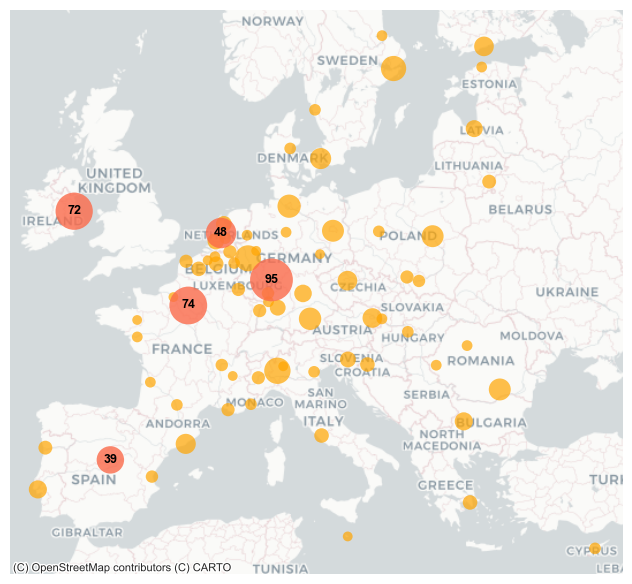

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))   

# Plot non-top5 bubbles in orange
gdf_bubbles[~gdf_bubbles["is_top5"]].plot(
    ax=ax,
    markersize=gdf_bubbles[~gdf_bubbles["is_top5"]]["count"] * 10,
    color='orange',
    alpha=0.7,
    edgecolor='none',
    linewidth=0.5
)

# Plot top5 bubbles in red  
gdf_bubbles[gdf_bubbles["is_top5"]].plot(
    ax=ax,
    markersize=gdf_bubbles[gdf_bubbles["is_top5"]]["count"] * 10,
    color='#fb6a4a',
    alpha=0.8,
    edgecolor='none',
    linewidth=0.5,
    label="Top 5 Clusters"
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf_bubbles.crs)

# Annotate only the top 5 clusters
for _, row in gdf_bubbles[gdf_bubbles["is_top5"]].iterrows():
    ax.text(
        row.geometry.x,
        row.geometry.y,
        f"{int(row['count'])}",
        fontsize=9,
        ha='center',
        va='center',
        color='black',
        fontweight='bold'
    )

ax.set_axis_off()
plt.tight_layout()
plt.savefig("../figures/dc_cluster_bubble_map.svg", dpi=300, bbox_inches='tight')
plt.show()


### Country-Level Energy Consumption Summary (TWh/year)

In [25]:
# Aggregate total energy use by country and scenario
energy_summary = gdf.groupby("country_normalized")[[
    "energy_low_twh", "energy_mid_twh", "energy_high_twh"
]].sum().round(2)

# Sort by mid scenario
energy_summary_sorted = energy_summary.sort_values("energy_mid_twh", ascending=False)
energy_summary

,energy_low_twh,energy_mid_twh,energy_high_twh
country_normalized,,,
Austria,0.85,0.97,1.09
Belgium,0.66,0.74,0.82
Bulgaria,0.31,0.35,0.39
Croatia,0.16,0.18,0.21
Cyprus,0.55,0.62,0.70
Czech Republic,0.43,0.48,0.54
Denmark,1.81,1.89,1.97
Estonia,0.12,0.13,0.15
Finland,0.88,0.99,1.10


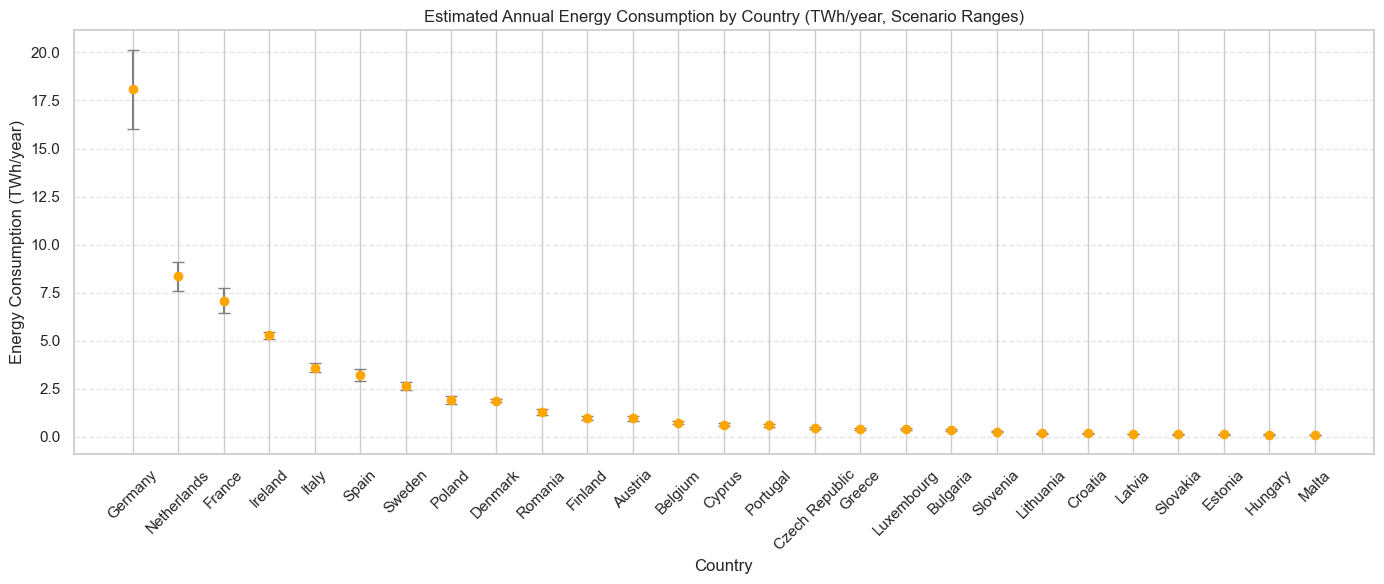

In [9]:
# Aggregate total energy use by country and scenario
energy_summary = (
    gdf.groupby("country_normalized")[["energy_low_twh", "energy_mid_twh", "energy_high_twh"]]
    .sum()
    .round(2)
    .reset_index()  # <- this is the fix
)

# Calculate error margins
energy_summary["yerr_low"] = energy_summary["energy_mid_twh"] - energy_summary["energy_low_twh"]
energy_summary["yerr_high"] = energy_summary["energy_high_twh"] - energy_summary["energy_mid_twh"]

# Sort by mid for better readability
df_energy_sorted = energy_summary.sort_values("energy_mid_twh", ascending=False)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.errorbar(
    x=df_energy_sorted["country_normalized"],
    y=df_energy_sorted["energy_mid_twh"],
    yerr=[df_energy_sorted["yerr_low"], df_energy_sorted["yerr_high"]],
    fmt='o', capsize=4, ecolor='grey', color='orange'
)
plt.title("Estimated Annual Energy Consumption by Country (TWh/year, Scenario Ranges)")
plt.xlabel("Country")
plt.ylabel("Energy Consumption (TWh/year)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("../figures/energy_estimates_by_country_scenarios.png", dpi=300)
plt.show()


In [27]:
# Aggregate total energy use by REGION and scenario
energy_summary_region = gdf.groupby("region")[[
    "energy_low_twh", "energy_mid_twh", "energy_high_twh"
]].sum().round(2)

# Sort by mid scenario energy consumption
energy_summary_region_sorted = energy_summary_region.sort_values("energy_mid_twh", ascending=False)

# Display
energy_summary_region_sorted


,energy_low_twh,energy_mid_twh,energy_high_twh
region,,,
Western Europe,31.88,35.60,39.32
Northern Europe,10.62,11.26,11.90
Southern Europe,7.83,8.59,9.35
Eastern Europe,4.20,4.74,5.27


In [29]:
# After groupby
gdf_region_energy = (
    gdf.groupby(["region", "country_normalized"])[["energy_low_twh", "energy_mid_twh", "energy_high_twh"]]
    .sum()
    .round(2)
    .reset_index()
)

# Add these two columns:
gdf_region_energy["yerr_low"] = gdf_region_energy["energy_mid_twh"] - gdf_region_energy["energy_low_twh"]
gdf_region_energy["yerr_high"] = gdf_region_energy["energy_high_twh"] - gdf_region_energy["energy_mid_twh"]

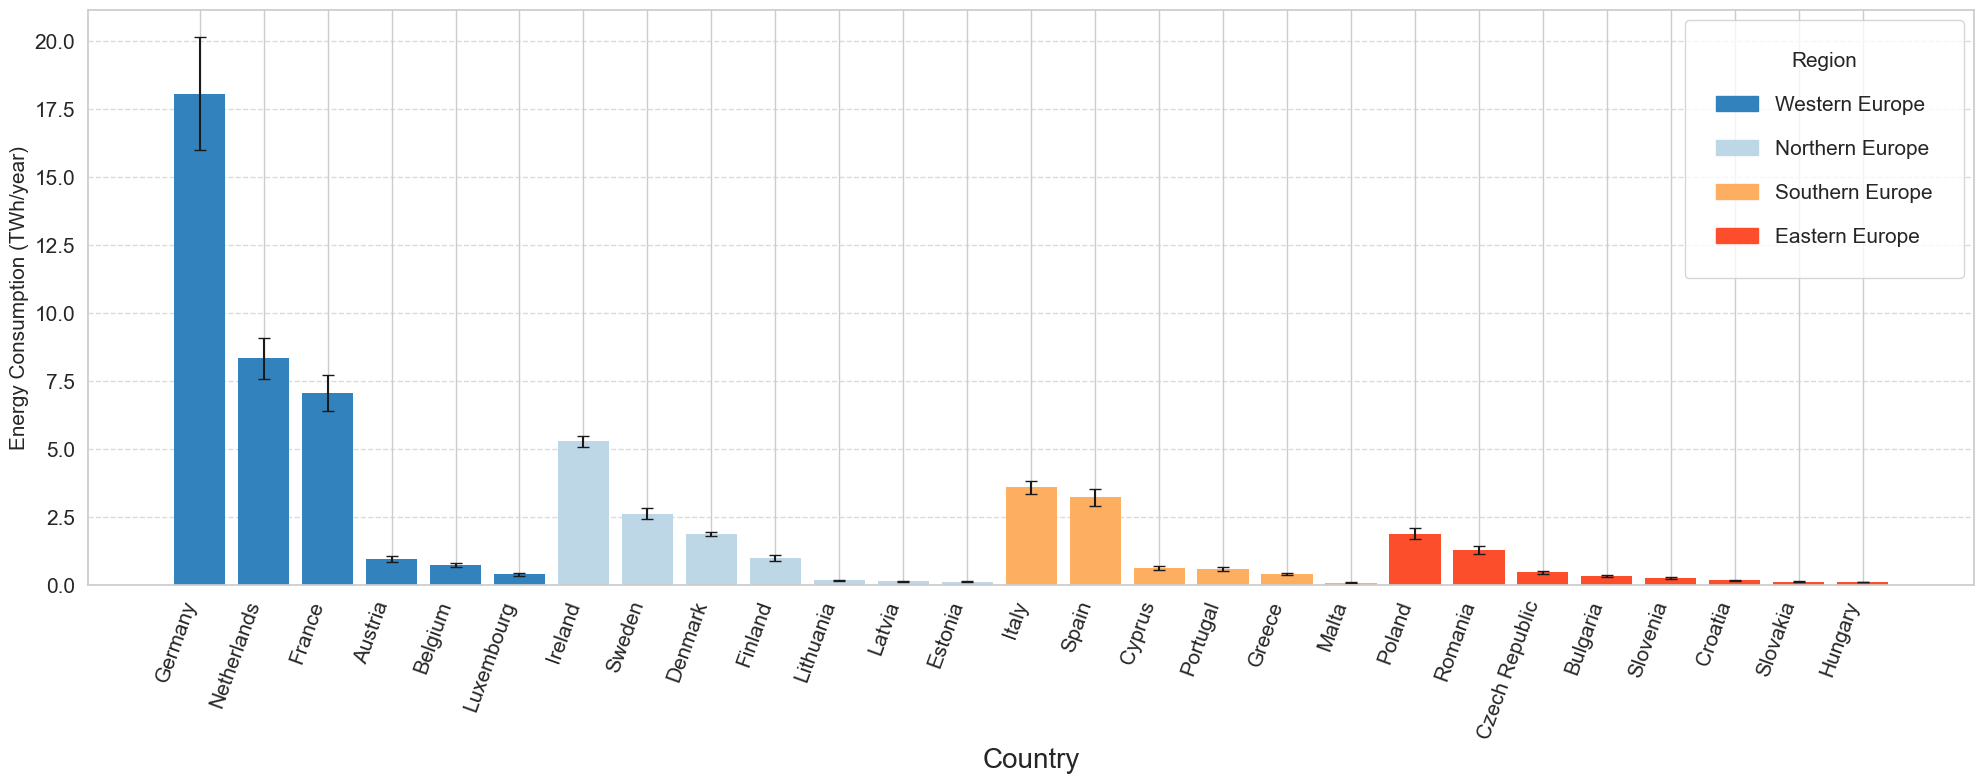

In [31]:
# Set the custom region order
region_order = ['Western Europe', 'Northern Europe', 'Southern Europe', 'Eastern Europe']

# Sort the dataframe by region (custom order), then by energy consumption
df_sorted = (
    gdf_region_energy.assign(region_cat=pd.Categorical(gdf_region_energy['region'], categories=region_order, ordered=True))
    .sort_values(["region_cat", "energy_mid_twh"], ascending=[True, False])
)

# Define colors again (same)
region_colors = {
    'Western Europe': '#3182bd',    
    'Northern Europe': '#bdd7e7',  
    'Southern Europe': '#fdae61',   
    'Eastern Europe': '#fc4e2a'     
}
colors = df_sorted['region'].map(region_colors)

# Plot
plt.figure(figsize=(20, 8))  # make figure wider
bars = plt.bar(
    df_sorted["country_normalized"],
    df_sorted["energy_mid_twh"],
    yerr=[df_sorted["yerr_low"], df_sorted["yerr_high"]],
    capsize=4,
    color=colors,
    edgecolor='none'
)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=70, ha='right', fontsize=15)  # more rotation + larger
plt.yticks(fontsize=15)
plt.ylabel('Energy Consumption (TWh/year)', fontsize=15)
plt.xlabel('Country', fontsize=20)
plt.tight_layout()

# Legend stays the same
handles = [plt.Rectangle((0,0),1,1, color=col) for col in region_colors.values()]
labels = region_colors.keys()
plt.legend(
    handles=handles,
    labels=labels,
    title="Region",
    loc='upper right',
    title_fontsize=15,
    fontsize=15,
    markerscale=2.0,
    borderpad=1.5,
    labelspacing=1.2
)

plt.savefig("../figures/energy_estimates_by_country_grouped_region.svg", dpi=300)
plt.show()

### Share of the total energy consumption by country

In [33]:
# Data retrieved from https://ec.europa.eu/eurostat/databrowser/view/ten00124/default/table?lang=en
df_eurostat= pd.read_csv("../input/ElectricityData/Eurostat/estat_nrg_bal_c_filtered_en.csv", low_memory=False)

In [35]:
eu27_countries = [
    "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark", 
    "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Ireland", 
    "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Poland", 
    "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden"
]

In [ ]:
df_filtered = df_eurostat[
    (df_eurostat["nrg_bal"] == "Available for final consumption") &
    (df_eurostat["siec"] == "Electricity") &
    (df_eurostat["unit"] == "Gigawatt-hour") &
    (df_eurostat["TIME_PERIOD"] == 2021) &
    (df_eurostat["geo"].isin(eu27_countries))
].copy()

In [37]:
# Convert GWh → TWh
df_filtered["total_load_twh"] = df_filtered["OBS_VALUE"] / 1000

In [ ]:
# Renaming for merge compatibility
name_map = {
    "Czechia": "Czech Republic"
}

df_filtered["country_normalized"] = df_filtered["geo"].replace(name_map)

In [39]:
df_dc_energy = gdf.groupby("country_normalized")[["energy_low_twh", "energy_mid_twh", "energy_high_twh"]].sum().reset_index()

In [40]:
df_merged = df_dc_energy.merge(
    df_filtered[["country_normalized", "total_load_twh"]],
    on="country_normalized",
    how="left"
)

# Compute DC share of total national electricity use
df_merged["share_low_pct"] = (df_merged["energy_low_twh"] / df_merged["total_load_twh"] * 100).round(2)
df_merged["share_mid_pct"] = (df_merged["energy_mid_twh"] / df_merged["total_load_twh"] * 100).round(2)
df_merged["share_high_pct"] = (df_merged["energy_high_twh"] / df_merged["total_load_twh"] * 100).round(2)
df_merged

,country_normalized,energy_low_twh,energy_mid_twh,energy_high_twh,total_load_twh,share_low_pct,share_mid_pct,share_high_pct
0,Austria,0.854438,0.970486,1.086534,64.453213,1.33,1.51,1.69
1,Belgium,0.663896,0.741684,0.819472,82.266500,0.81,0.90,1.00
2,Bulgaria,0.313835,0.353311,0.392787,30.581181,1.03,1.16,1.28
3,Croatia,0.163140,0.184121,0.205102,16.495400,0.99,1.12,1.24
4,Cyprus,0.546057,0.621653,0.697248,4.650144,11.74,13.37,14.99
5,Czech Republic,0.427823,0.483968,0.540112,60.836963,0.70,0.80,0.89
6,Denmark,1.807648,1.888110,1.968572,32.375522,5.58,5.83,6.08
7,Estonia,0.115482,0.130629,0.145777,7.848928,1.47,1.66,1.86
8,Finland,0.876829,0.986586,1.096342,82.092231,1.07,1.20,1.34
9,France,6.420270,7.071678,7.723085,432.374726,1.48,1.64,1.79


In [41]:
df_merged = df_merged.sort_values("share_mid_pct", ascending=False)

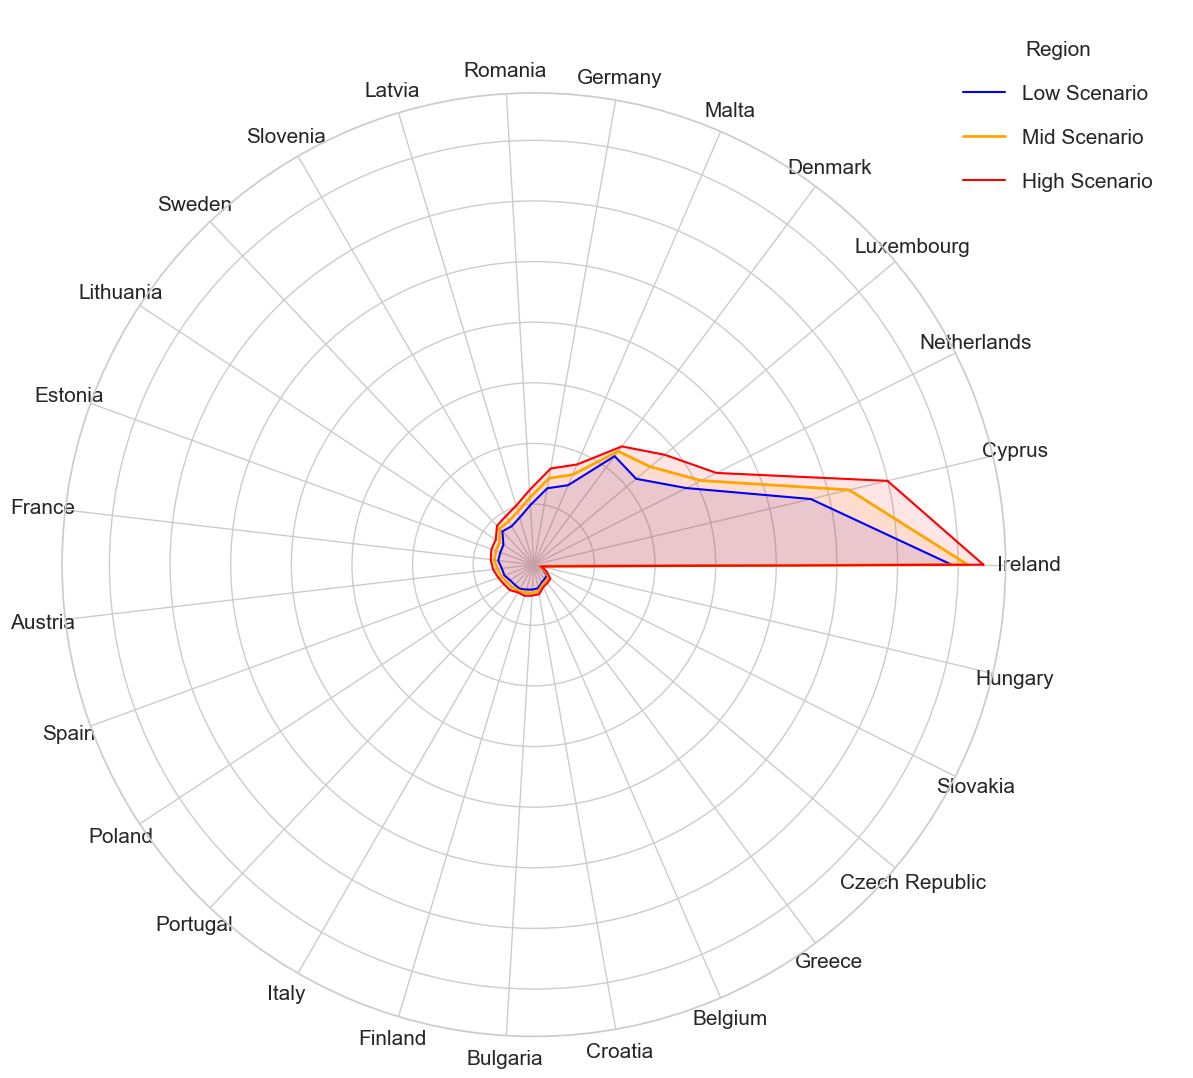

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
labels = df_merged["country_normalized"]
stats_low = df_merged["share_low_pct"].tolist()
stats_mid = df_merged["share_mid_pct"].tolist()
stats_high = df_merged["share_high_pct"].tolist()

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()

# Close the circular plot
stats_low += stats_low[:1]
stats_mid += stats_mid[:1]
stats_high += stats_high[:1]
angles += angles[:1]

# Set up plot
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

# Plot each scenario
ax.plot(angles, stats_low, linewidth=1.5, linestyle='solid', label='Low Scenario', color='blue')
ax.plot(angles, stats_mid, linewidth=2, linestyle='solid', label='Mid Scenario', color='orange')
ax.plot(angles, stats_high, linewidth=1.5, linestyle='solid', label='High Scenario', color='red')

# Fill under each curve slightly
ax.fill(angles, stats_low, alpha=0.1, color='blue')
ax.fill(angles, stats_mid, alpha=0.1, color='orange')
ax.fill(angles, stats_high, alpha=0.1, color='red')

# Decorations
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=15)

# Add legend
plt.legend(
    title="Region",
    loc='upper right',
    title_fontsize=15,
    bbox_to_anchor=(1.2, 1.1),
    frameon=False,
    fontsize=15,
    markerscale=2.0,
    borderpad=1.5,
    labelspacing=1.2
)

plt.tight_layout()

# Save figure
output_path = "../figures/electricity_shares.svg"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()


In [47]:
total_eu27_load_twh = df_filtered["OBS_VALUE"].sum() / 1000  # GWh → TWh
print(f"Total electricity consumption in EU27 (2021): {total_eu27_load_twh:.1f} TWh")

Total electricity consumption in EU27 (2021): 2495.4 TWh


In [48]:
total_dc_energy_low = gdf["energy_low_twh"].sum()
total_dc_energy_mid = gdf["energy_mid_twh"].sum()
total_dc_energy_high = gdf["energy_high_twh"].sum()


In [49]:
share_dc_eu27_low = (total_dc_energy_low / total_eu27_load_twh) * 100
share_dc_eu27_mid = (total_dc_energy_mid / total_eu27_load_twh) * 100
share_dc_eu27_high = (total_dc_energy_high / total_eu27_load_twh) * 100

In [50]:
print(f"Total EU27 electricity consumption (2021): {total_eu27_load_twh:.1f} TWh")

print(f"Data Center Energy Consumption:")
print(f"- Low scenario: {total_dc_energy_low:.1f} TWh ({share_dc_eu27_low:.2f}%)")
print(f"- Mid scenario: {total_dc_energy_mid:.1f} TWh ({share_dc_eu27_mid:.2f}%)")
print(f"- High scenario: {total_dc_energy_high:.1f} TWh ({share_dc_eu27_high:.2f}%)")


Total EU27 electricity consumption (2021): 2495.4 TWh
Data Center Energy Consumption:
- Low scenario: 54.5 TWh (2.19%)
- Mid scenario: 60.2 TWh (2.41%)
- High scenario: 65.8 TWh (2.64%)


### Emission Estimation

In [53]:
import geopandas as gpd
import pandas as pd

# Reload the emissions dataset
gdf = gpd.read_file("../output/12_data_center_emissions.geojson")

# Filter for valid geometry and emissions data
gdf = gdf[gdf.geometry.notnull() & gdf.geometry.is_valid]
gdf = gdf[gdf["emissions_mid_tons"].notna()]
gdf = gdf.set_crs("EPSG:4326")

# Compute total EU-wide emissions by scenario (in Mt CO₂e/year)
total_emissions_mt = {
    "low": gdf["emissions_low_tons"].sum() / 1e6,
    "mid": gdf["emissions_mid_tons"].sum() / 1e6,
    "high": gdf["emissions_high_tons"].sum() / 1e6,
}

# Display the cleaned total emissions
total_emissions_mt


{'low': 14.165342340424202,
 'mid': 15.665055763782483,
 'high': 17.164769187140717}

In [54]:
import pandas as pd

# Group by country ISO2 and sum emissions (in tons)
emissions_by_country = gdf.groupby("country_iso2").agg(
    emissions_low_tons=("emissions_low_tons", "sum"),
    emissions_mid_tons=("emissions_mid_tons", "sum"),
    emissions_high_tons=("emissions_high_tons", "sum"),
    number_of_dcs=("datacentername", "count")
).reset_index()

# Convert to Mt CO₂/year for readability
emissions_by_country["emissions_low_mt"] = (emissions_by_country["emissions_low_tons"] / 1e6).round(4)
emissions_by_country["emissions_mid_mt"] = (emissions_by_country["emissions_mid_tons"] / 1e6).round(4)
emissions_by_country["emissions_high_mt"] = (emissions_by_country["emissions_high_tons"] / 1e6).round(4)

# Keep only Mt columns and country code
emissions_by_country = emissions_by_country[[
    "country_iso2", "number_of_dcs",
    "emissions_low_mt", "emissions_mid_mt", "emissions_high_mt"
]]

# Sort by mid-scenario emissions
emissions_by_country = emissions_by_country.sort_values("emissions_mid_mt", ascending=False)

# Display top 10
emissions_by_country

,country_iso2,number_of_dcs,emissions_low_mt,emissions_mid_mt,emissions_high_mt
5,DE,341,5.3179,6.0075,6.6971
20,NL,148,2.0743,2.2797,2.4850
14,IE,74,2.0696,2.1482,2.2269
21,PL,74,1.1861,1.3335,1.4809
15,IT,129,0.8361,0.8994,0.9627
3,CY,11,0.3817,0.4345,0.4873
23,RO,53,0.3657,0.4121,0.4585
8,ES,111,0.3617,0.3995,0.4373
4,CZ,36,0.2040,0.2308,0.2576
6,DK,43,0.2172,0.2271,0.2370


In [8]:
from sklearn.cluster import DBSCAN
import numpy as np

# Ensure valid coordinates
gdf["lat"] = gdf.geometry.y
gdf["lon"] = gdf.geometry.x
coords_rad = np.radians(gdf[["lat", "lon"]].values)

# Run DBSCAN
eps_km = 15
kms_per_radian = 6371.0088
eps_rad = eps_km / kms_per_radian
db = DBSCAN(eps=eps_rad, min_samples=5, algorithm="ball_tree", metric="haversine")
gdf["cluster"] = db.fit_predict(coords_rad)


In [9]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from shapely.geometry import Point

# Load emissions data and clusters with DBSCAN results
shapes = gpd.read_file("../../GeoData/naturalearth/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

# Fix France ISO code
shapes["ISO_A2"] = shapes["ISO_A2"].replace({"FX": "FR"})
shapes.loc[shapes["ADMIN"] == "France", "ISO_A2"] = "FR"

# Explode multipolygons and filter to Europe
shapes = shapes.explode(index_parts=False, ignore_index=True)
shapes = shapes[shapes["CONTINENT"] == "Europe"]
france_mainland = shapes[(shapes["ISO_A2"] == "FR") & (shapes.geometry.bounds.minx > -10)]
non_france = shapes[shapes["ISO_A2"] != "FR"]
shapes = pd.concat([non_france, france_mainland], ignore_index=True)

# Aggregate CO₂ emissions per country
emissions = gdf.groupby("country_iso2")["emissions_mid_tons"].sum().reset_index()
emissions["emissions_mt"] = emissions["emissions_mid_tons"] / 1e6
eu_shapes = shapes[shapes["ISO_A2"].isin(emissions["country_iso2"])]
merged = eu_shapes.merge(emissions, left_on="ISO_A2", right_on="country_iso2", how="inner")

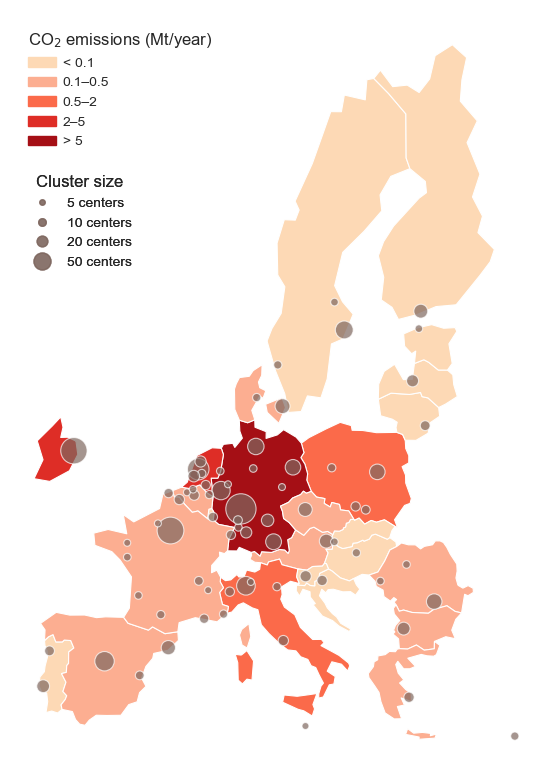

In [16]:
#### Graph 
# Define color bins and map colors
bins = [0, 0.1, 0.5, 2, 5, emissions["emissions_mt"].max() + 1]
labels = ["< 0.1", "0.1–0.5", "0.5–2", "2–5", "> 5"]
colors = ["#fdd9b5", "#fcae91", "#fb6a4a", "#de2d26", "#a50f15"]
color_map = dict(zip(labels, colors))
merged["category"] = pd.cut(merged["emissions_mt"], bins=bins, labels=labels, include_lowest=True)
merged["color"] = merged["category"].astype(str).map(color_map)

# Load actual clusters from DBSCAN ('cluster' column must exist in gdf)
gdf_clustered = gdf[(gdf["cluster"] != -1) & (gdf.geometry.notnull()) & (gdf.geometry.is_valid)].copy()
gdf_clustered = gdf_clustered.to_crs(epsg=3857)

# Compute cluster centroids
cluster_summary = gdf_clustered.groupby("cluster").agg(
    count=("cluster", "count"),
    x=("geometry", lambda x: x.centroid.x.mean()),
    y=("geometry", lambda x: x.centroid.y.mean())
).reset_index()

# Create GeoDataFrame of bubble centroids
bubble_gdf = gpd.GeoDataFrame(
    cluster_summary,
    geometry=gpd.points_from_xy(cluster_summary.x, cluster_summary.y),
    crs="EPSG:3857"
)

# Reproject country map
merged = merged.to_crs(epsg=3857)

# Plot map with clustered bubbles
fig, ax = plt.subplots(figsize=(12, 8))
merged.plot(ax=ax, color=merged["color"], edgecolor="white", linewidth=0.8)

# Plot clusters as scaled black bubbles
bubble_gdf.plot(
    ax=ax,
    markersize=bubble_gdf["count"] * 5,  # Slightly bigger bubbles
    color="#7F6860",     
    alpha=0.7,
    edgecolor="white",
    linewidth=0.8
)

# CO₂ emissions legend
emission_handles = [mpatches.Patch(color=color_map[l], label=l) for l in labels]
legend1 = ax.legend(
    handles=emission_handles,
    title="CO$_2$ emissions (Mt/year)",
    loc="upper left",
    bbox_to_anchor=(0.01, 0.99),
    frameon=False,
    fontsize=10,
    title_fontsize=12,
    handletextpad=0.5,    
    borderaxespad=0.5,   
    alignment='left'     
)
ax.add_artist(legend1)

# Cluster size legend
cluster_sizes = [5, 10, 20, 50]  # Scale the example clusters for clarity
cluster_handles = [
    Line2D([], [], marker='o', linestyle='', markersize=(s * 3) ** 0.5,
           color='#7F6860', alpha=0.7, label=f'{s} centers')
    for s in cluster_sizes
]
legend2 = ax.legend(
    handles=cluster_handles,
    title="Cluster size",
    loc="upper left",
    bbox_to_anchor=(0.01, 0.80),
    frameon=False,
    fontsize=10,
    title_fontsize=12
)
ax.add_artist(legend2)

# Title and final styling
ax.set_axis_off()
plt.tight_layout()

# Save figure
plt.savefig("../figures/emissions_clusters_updated.png", dpi=300, bbox_inches='tight')

plt.show()

### Graph correlation

In [18]:
import pandas as pd

# Group emissions and energy consumption by country
emissions_energy_by_country = gdf.groupby("country_iso2").agg(
    emissions_low_tons=("emissions_low_tons", "sum"),
    emissions_mid_tons=("emissions_mid_tons", "sum"),
    emissions_high_tons=("emissions_high_tons", "sum"),
    energy_low_twh=("energy_low_twh", "sum"),
    energy_mid_twh=("energy_mid_twh", "sum"),
    energy_high_twh=("energy_high_twh", "sum"),
    avg_carbon_intensity_gco2_kwh=("avg_carbon_intensity_gco2_kwh", "mean"),
    number_of_dcs=("datacentername", "count")
).reset_index()

# Convert emissions from tons to Mt CO₂/year
emissions_energy_by_country["emissions_low_mt"] = (emissions_energy_by_country["emissions_low_tons"] / 1e6).round(4)
emissions_energy_by_country["emissions_mid_mt"] = (emissions_energy_by_country["emissions_mid_tons"] / 1e6).round(4)
emissions_energy_by_country["emissions_high_mt"] = (emissions_energy_by_country["emissions_high_tons"] / 1e6).round(4)

# Keep only needed columns
emissions_energy_by_country = emissions_energy_by_country[[
    "country_iso2", "number_of_dcs",
    "energy_low_twh", "energy_mid_twh", "energy_high_twh",
    "emissions_low_mt", "emissions_mid_mt", "emissions_high_mt", "avg_carbon_intensity_gco2_kwh"
]]

# Sort by mid-scenario emissions
emissions_energy_by_country = emissions_energy_by_country.sort_values("emissions_mid_mt", ascending=False)

# Display
emissions_energy_by_country.head(10)


,country_iso2,number_of_dcs,energy_low_twh,energy_mid_twh,energy_high_twh,emissions_low_mt,emissions_mid_mt,emissions_high_mt,avg_carbon_intensity_gco2_kwh
5,DE,341,15.991730,18.065538,20.139346,5.3179,6.0075,6.6971,332.540000
20,NL,148,7.600210,8.352538,9.104866,2.0743,2.2797,2.4850,272.930000
14,IE,74,5.095368,5.289031,5.482694,2.0696,2.1482,2.2269,406.170000
21,PL,74,1.686695,1.896302,2.105908,1.1861,1.3335,1.4809,703.190000
15,IT,129,3.353348,3.598049,3.842750,0.8361,0.8994,0.9627,253.828682
3,CY,11,0.546057,0.621653,0.697248,0.3817,0.4345,0.4873,698.950000
23,RO,53,1.146111,1.291472,1.436833,0.3657,0.4121,0.4585,319.120000
8,ES,111,2.932060,3.238799,3.545538,0.3617,0.3995,0.4373,123.350000
4,CZ,36,0.427823,0.483968,0.540112,0.2040,0.2308,0.2576,476.880000
6,DK,43,1.807648,1.888110,1.968572,0.2172,0.2271,0.2370,122.255349


Fit equation: log10(y) = 0.88 * log10(x) + -0.70
R² = 0.72


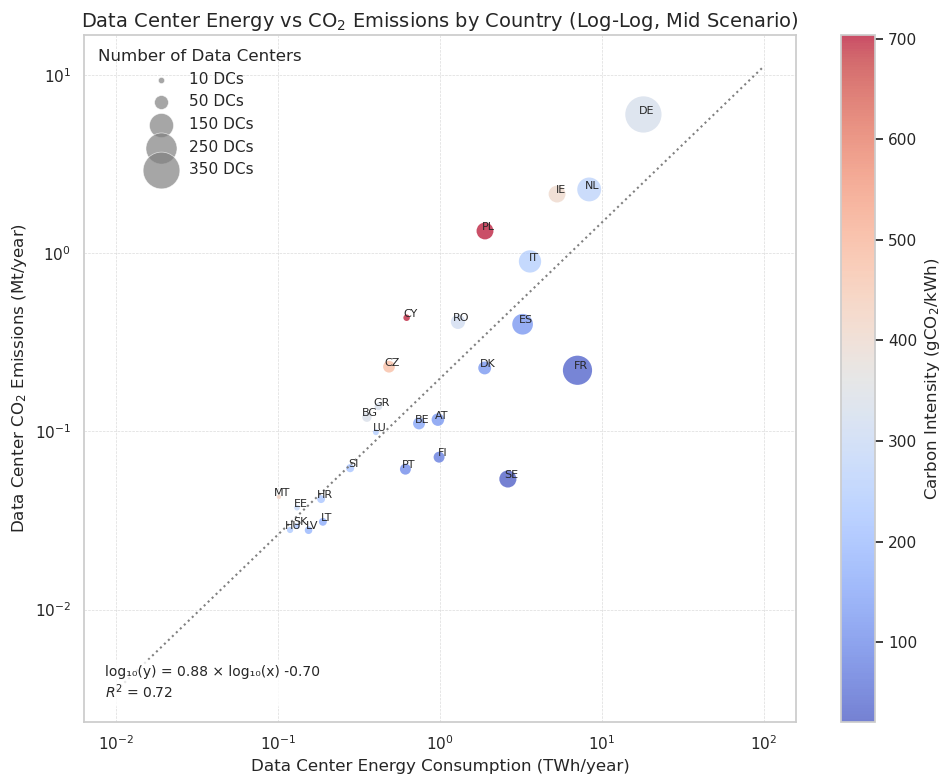

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'

# Set up figure
plt.figure(figsize=(10, 8))

# Main scatter plot
sc = plt.scatter(
    emissions_energy_by_country['energy_mid_twh'],
    emissions_energy_by_country['emissions_mid_mt'],
    c=emissions_energy_by_country['avg_carbon_intensity_gco2_kwh'],
    cmap='coolwarm',
    s=emissions_energy_by_country['number_of_dcs'] * 2,  # scaling
    edgecolor='none',
    alpha=0.7
)

# Plot the reference 1:1 line in log-log space
x = np.logspace(-2, 2, 100)

# Country labels
for i, row in emissions_energy_by_country.iterrows():
    plt.text(
        row['energy_mid_twh']*1.05,
        row['emissions_mid_mt']*1.05,
        row['country_iso2'],
        fontsize=8,
        ha='center',
        va='center'
    )

# Log-log scales
plt.xscale('log')
plt.yscale('log')

# Grids
plt.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.7)
plt.grid(which='minor', linestyle='', linewidth=0)

# Axis labels and title
plt.xlabel('Data Center Energy Consumption (TWh/year)', fontsize=12)
plt.ylabel('Data Center CO$_2$ Emissions (Mt/year)', fontsize=12)
plt.title('Data Center Energy vs CO$_2$ Emissions by Country (Log-Log, Mid Scenario)', fontsize=14)

# Colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Carbon Intensity (gCO$_2$/kWh)')

# Bubble size legend (custom)
bubble_sizes = [10, 50, 150, 250, 350]
bubble_handles = [
    plt.scatter([], [], 
                s=size*2, 
                color='grey', 
                alpha=0.7, 
                edgecolors='white',
                linewidth=0.5,
                label=f'{size} DCs')
    for size in bubble_sizes
]
plt.legend(handles=bubble_handles, title='Number of Data Centers', loc='upper left', frameon=False)

# Fit a regression line in log-log space
x_log = np.log10(emissions_energy_by_country['energy_mid_twh'])
y_log = np.log10(emissions_energy_by_country['emissions_mid_mt'])

slope, intercept, r_value, p_value, std_err = linregress(x_log, y_log)

# Print fit results
print(f"Fit equation: log10(y) = {slope:.2f} * log10(x) + {intercept:.2f}")
print(f"R² = {r_value**2:.2f}")

# Plot the fit line
x_fit = np.logspace(-2, 2, 100)
y_fit = 10**(slope * np.log10(x_fit) + intercept)
plt.plot(x_fit, y_fit, color='grey', linestyle=':', label=f'Fit: slope={slope:.2f}, $R^2$={r_value**2:.2f}')

# Add fit equation as a text box inside the plot
eq_text = f"log₁₀(y) = {slope:.2f} × log₁₀(x) {intercept:+.2f}\n$R^2$ = {r_value**2:.2f}"

plt.text(0.03, 0.03, eq_text, 
         transform=plt.gca().transAxes, 
         fontsize=10, 
         verticalalignment='bottom', 
         horizontalalignment='left',
         bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='none'))

# Final layout
plt.tight_layout()
plt.savefig('../figures/energy_vs_emissions_loglog_refined_with_fit.png', dpi=300)
plt.show()
